> [Detrended Fluctuation Analysis in the prediction of type 2 diabetes mellitus in patients at risk: Model optimization and comparison with other metrics](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0225817)


# Preliminary Analysis

## 1. Load Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import glob
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# 3️⃣ Load clinical data
clinical_path = '/content/drive/MyDrive/Research Project/Continuous Glucose Monitoring Data/S1/clinical_data.txt'
clinical_df = pd.read_csv(clinical_path, sep=" ")
print("\n")
print("="*80, "]")
print(f"Clinical_data.txt imported.")

# Load each patients data
s1_folder_path = '/content/drive/MyDrive/Research Project/Continuous Glucose Monitoring Data/S1'
case_csv_files = glob.glob(os.path.join(s1_folder_path, 'case*.csv'))
cnt = 0
for file_path in case_csv_files:
  # print(file_path)
  cnt += 1
print(f'Total {cnt} Patient files Loaded.')

## Descriptive statistics




### Clininal Data

**Clininal Data Overview:**

* *gender (0 = male, 1 = female)*
* *age (years)*
* *body mass index (Kg/m2)*
* *basal glycaemia (mg/dL)*
* *HbA1c (%)*
* *follow-up (days)*
* *final diagnosis of type 2 diabetes mellitus*

In [79]:
clinical_df.describe()

,gender,age,BMI,glycaemia,HbA1c,follow.up
count,208.000000,208.000000,207.000000,208.000000,200.000000,196.000000
mean,0.504808,59.600962,29.993237,100.581731,5.763500,979.831633
std,0.501183,10.094692,4.738661,11.407814,0.295558,371.916226
min,0.000000,29.000000,18.100000,78.000000,5.100000,176.000000
25%,0.000000,54.000000,27.000000,92.000000,5.600000,678.500000
50%,1.000000,61.000000,29.300000,101.000000,5.800000,992.500000
75%,1.000000,66.000000,32.400000,108.000000,6.000000,1254.250000
max,1.000000,88.000000,48.700000,135.000000,6.500000,2211.000000


### Individual Patient Data

**Goal**
* Mean glucose  For each patient and for the whole dataset.
* Median glucose For each patient and for the whole dataset.
* Standard deviation:  For each patient and for the whole dataset.
* Minimum glucose: For each patient and for the whole dataset.
* Maximum glucose: For each patient and for the whole dataset.
* Range = max – min :For each patient and for the whole dataset.
* Coefficient of variation (CV) = SD / Mean : For each patient and for the whole dataset.
* percentage of readings <70 mg/dL  only for each patient.
* Percentage of readings between 70–170 mg/dL  only for each patient
* Percentage  of readings >170 mg/dL  only for each patient.



#### **Whole Dataset**
Compute the Overall descriptive statistics for the 'glucemia' column across all loaded DataFrames.

In [80]:
all_glucemia_data = pd.concat([pd.read_csv(file_path)['glucemia'] for file_path in case_csv_files])

overall_mean_glucose = all_glucemia_data.mean()
overall_median_glucose = all_glucemia_data.median()
overall_std_glucose = all_glucemia_data.std()
overall_min_glucose = all_glucemia_data.min()
overall_max_glucose = all_glucemia_data.max()
overall_range_glucose = overall_max_glucose - overall_min_glucose
overall_cv_glucose = (overall_std_glucose / overall_mean_glucose) if overall_mean_glucose != 0 else np.nan

overall_stats = {
    'mean': overall_mean_glucose,
    'median': overall_median_glucose,
    'std': overall_std_glucose,
    'min': overall_min_glucose,
    'max': overall_max_glucose,
    'range': overall_range_glucose,
    'cv': overall_cv_glucose,
}

#### **Individual Patient**
Calculated descriptive statistics for each patient and for the whole dataset.


In [81]:
case_stats_list = []

for file_path in case_csv_files:
    df_case = pd.read_csv(file_path)
    glucemia_data = df_case['glucemia']

    mean_glucose = glucemia_data.mean()
    median_glucose = glucemia_data.median()
    std_glucose = glucemia_data.std()
    min_glucose = glucemia_data.min()
    max_glucose = glucemia_data.max()
    range_glucose = max_glucose - min_glucose
    cv_glucose = (std_glucose / mean_glucose) if mean_glucose != 0 else np.nan

    percent_lt_70 = (glucemia_data < 70).mean() * 100
    percent_70_170 = ((glucemia_data >= 70) & (glucemia_data <= 170)).mean() * 100
    percent_gt_170 = (glucemia_data > 170).mean() * 100

    case_stats = {
        'file_name': os.path.basename(file_path),
        'mean': mean_glucose,
        'median': median_glucose,
        'std': std_glucose,
        'min': min_glucose,
        'max': max_glucose,
        'range': range_glucose,
        'cv': cv_glucose,
        '% < 70': percent_lt_70,
        '% 70-170': percent_70_170,
        '% > 170': percent_gt_170,
    }
    case_stats_list.append(case_stats)

case_stats_df = pd.DataFrame(case_stats_list)

**Display the calculated descriptive statistics for each patient and for the whole dataset.**

In [82]:
print('\033[1m' + "\nOverall Descriptive Statistics for Glucose Levels:" + '\033[0m', "\n")
display(pd.DataFrame([overall_stats]))
print('\n\n\n',"-"*100,"\n")

print('\033[1m' +  "Descriptive Statistics for Each Patient:" + '\033[0m', "\n")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(case_stats_df)


Overall Descriptive Statistics for Glucose Levels: 



,mean,median,std,min,max,range,cv
0,102.320342,100.0,21.805964,40.0,318.0,278.0,0.213115





 ---------------------------------------------------------------------------------------------------- 

Descriptive Statistics for Each Patient: 



,file_name,mean,median,std,min,max,range,cv,% < 70,% 70-170,% > 170
0,case 29.csv,111.399306,107.0,31.264153,67.0,212.0,145.0,0.280649,4.687500,89.236111,6.076389
1,case 118.csv,99.352415,97.0,9.926393,82.0,131.0,49.0,0.099911,0.000000,97.048611,0.000000
2,case 27.csv,118.656250,117.0,18.541138,76.0,190.0,114.0,0.156259,0.000000,98.263889,1.736111
3,case 32.csv,97.583333,93.0,15.664193,70.0,151.0,81.0,0.160521,0.000000,100.000000,0.000000
4,case 126.csv,96.807292,94.0,19.110917,54.0,143.0,89.0,0.197412,6.423611,93.576389,0.000000
5,case 16.csv,105.305556,105.0,8.196099,87.0,132.0,45.0,0.077832,0.000000,100.000000,0.000000
6,case 114.csv,101.951389,97.0,15.022802,81.0,153.0,72.0,0.147353,0.000000,100.000000,0.000000
7,case 33.csv,102.699653,99.0,12.343281,79.0,135.0,56.0,0.120188,0.000000,100.000000,0.000000
8,case 131.csv,103.371528,102.0,10.623231,74.0,141.0,67.0,0.102767,0.000000,100.000000,0.000000
9,case 119.csv,90.954861,88.0,20.048152,45.0,142.0,97.0,0.220419,11.979167,88.020833,0.000000


## Visualize Descriptive Statistics

Generate plots to visualize the distribution of descriptive statistics across patients.

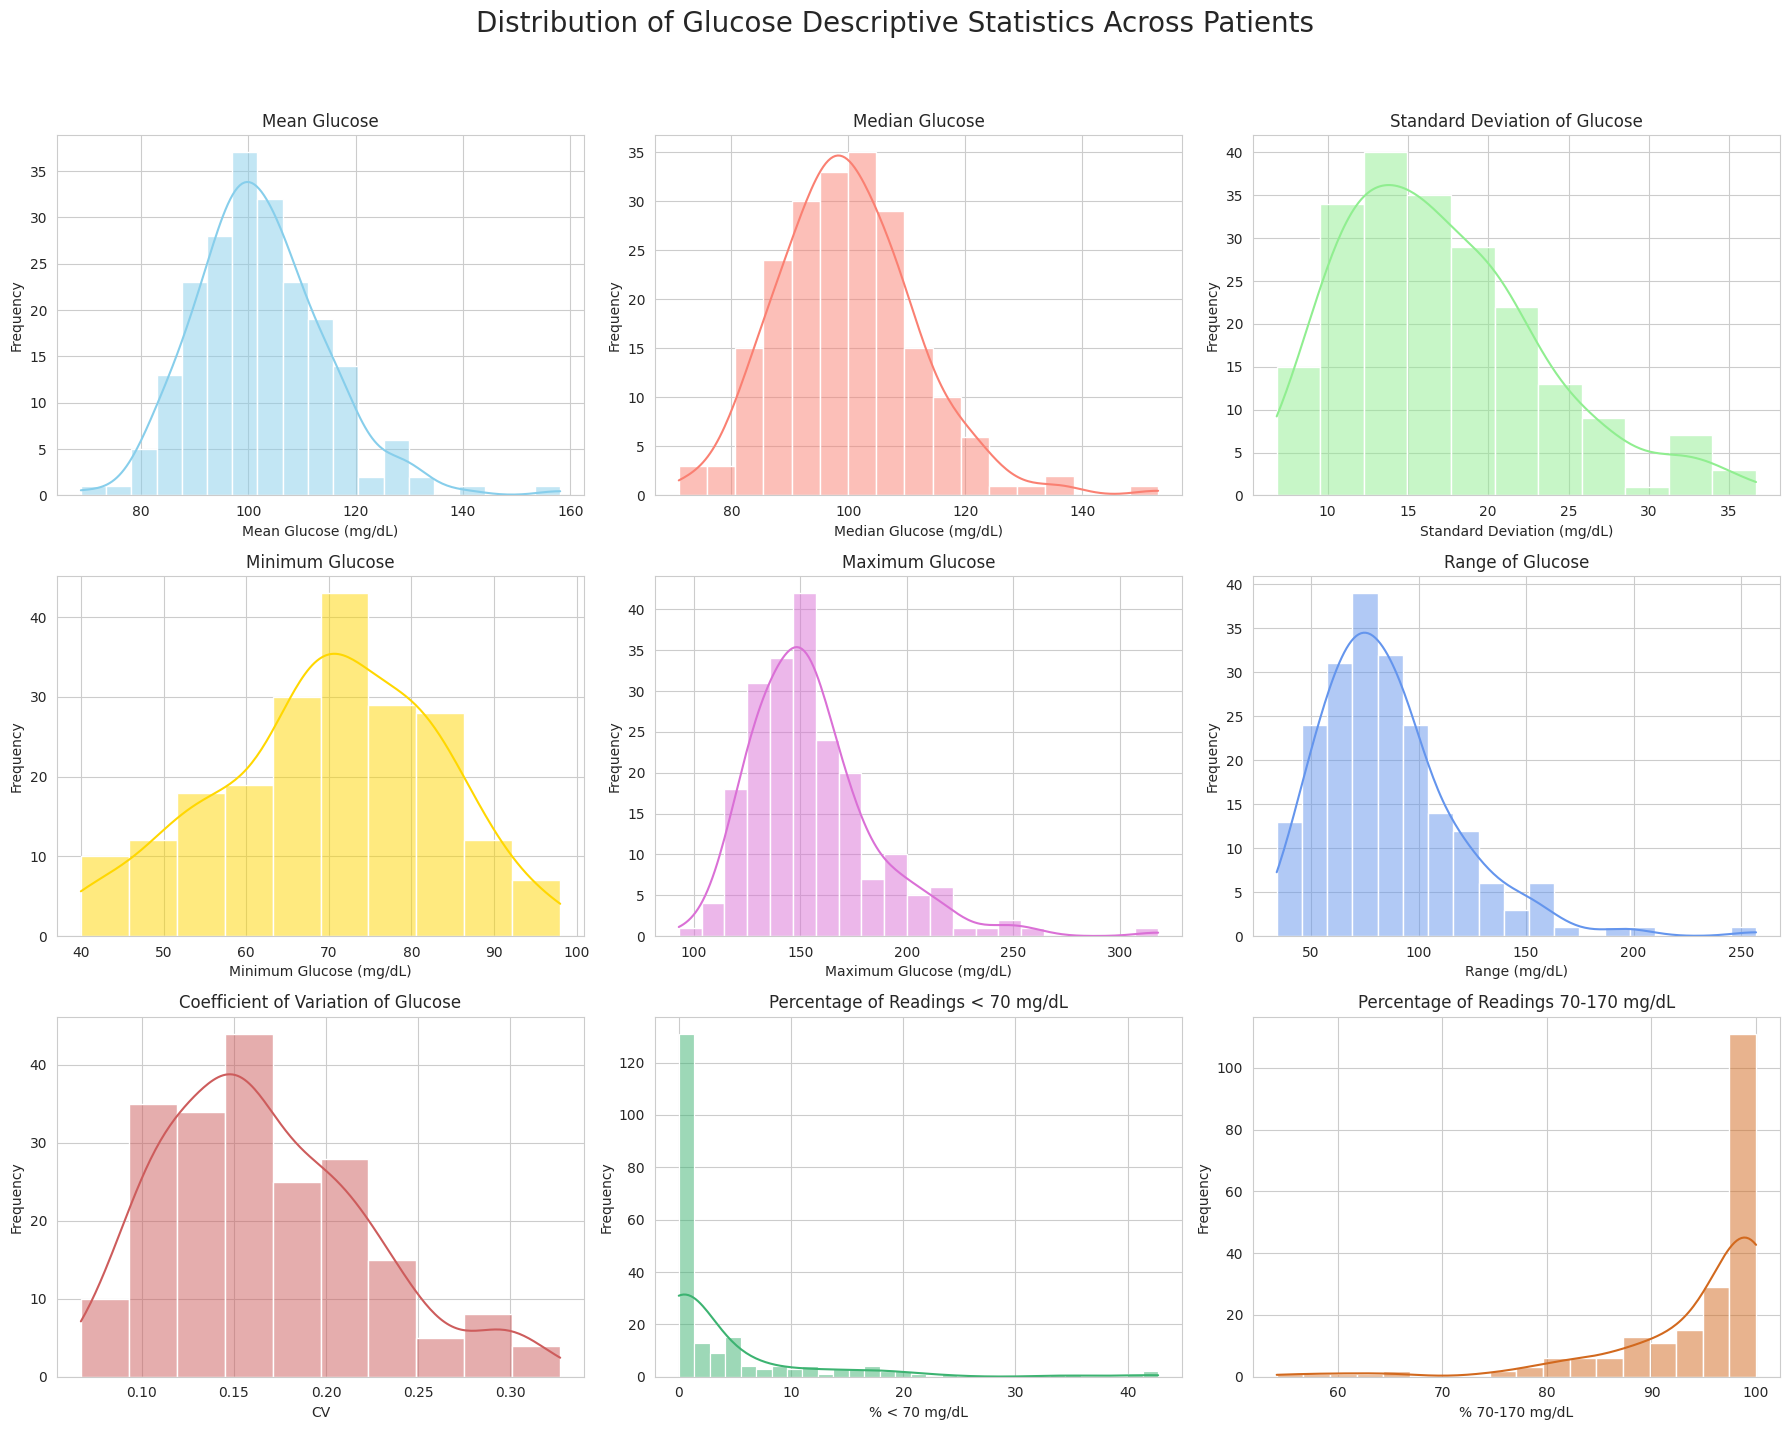

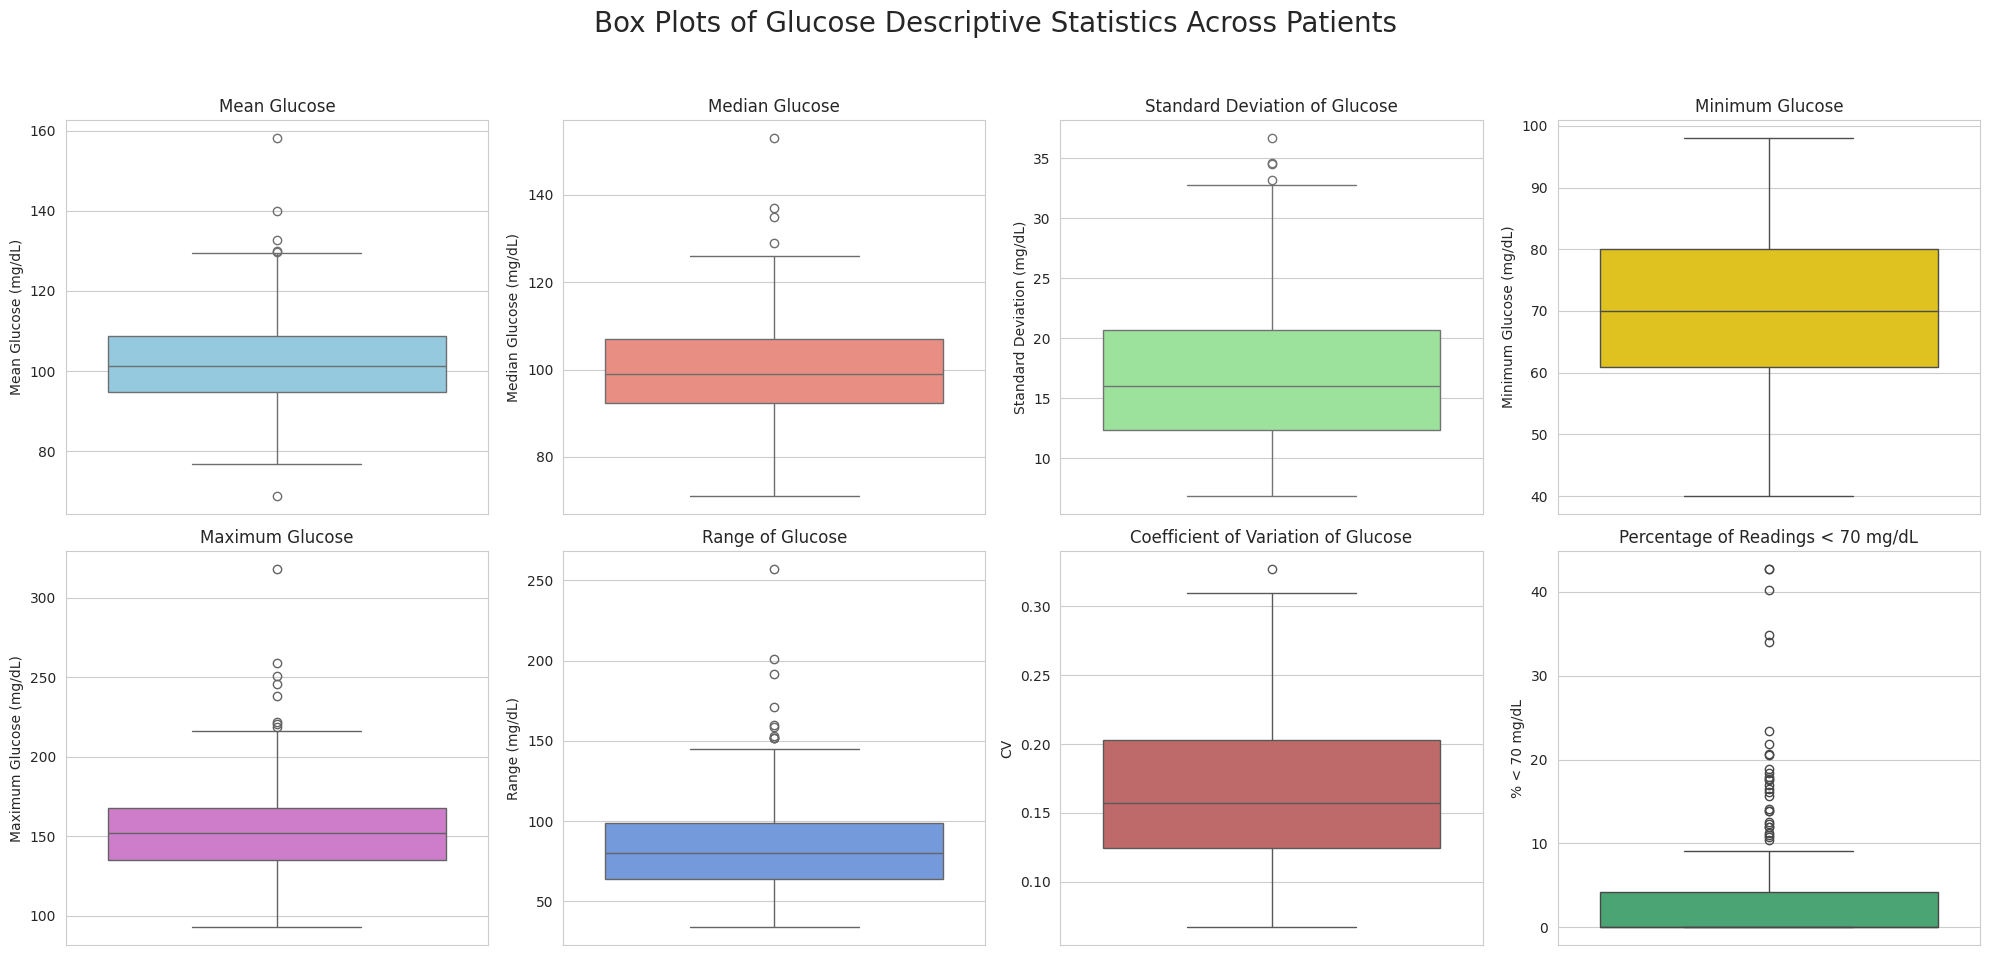

In [83]:
# @title Code for Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create histograms for key statistics
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
fig.suptitle('Distribution of Glucose Descriptive Statistics Across Patients', fontsize=20)

sns.histplot(case_stats_df['mean'], ax=axes[0, 0], kde=True, color='skyblue')
axes[0, 0].set_title('Mean Glucose')
axes[0, 0].set_xlabel('Mean Glucose (mg/dL)')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(case_stats_df['median'], ax=axes[0, 1], kde=True, color='salmon')
axes[0, 1].set_title('Median Glucose')
axes[0, 1].set_xlabel('Median Glucose (mg/dL)')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(case_stats_df['std'], ax=axes[0, 2], kde=True, color='lightgreen')
axes[0, 2].set_title('Standard Deviation of Glucose')
axes[0, 2].set_xlabel('Standard Deviation (mg/dL)')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(case_stats_df['min'], ax=axes[1, 0], kde=True, color='gold')
axes[1, 0].set_title('Minimum Glucose')
axes[1, 0].set_xlabel('Minimum Glucose (mg/dL)')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(case_stats_df['max'], ax=axes[1, 1], kde=True, color='orchid')
axes[1, 1].set_title('Maximum Glucose')
axes[1, 1].set_xlabel('Maximum Glucose (mg/dL)')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(case_stats_df['range'], ax=axes[1, 2], kde=True, color='cornflowerblue')
axes[1, 2].set_title('Range of Glucose')
axes[1, 2].set_xlabel('Range (mg/dL)')
axes[1, 2].set_ylabel('Frequency')

sns.histplot(case_stats_df['cv'], ax=axes[2, 0], kde=True, color='indianred')
axes[2, 0].set_title('Coefficient of Variation of Glucose')
axes[2, 0].set_xlabel('CV')
axes[2, 0].set_ylabel('Frequency')

sns.histplot(case_stats_df['% < 70'], ax=axes[2, 1], kde=True, color='mediumseagreen')
axes[2, 1].set_title('Percentage of Readings < 70 mg/dL')
axes[2, 1].set_xlabel('% < 70 mg/dL')
axes[2, 1].set_ylabel('Frequency')

sns.histplot(case_stats_df['% 70-170'], ax=axes[2, 2], kde=True, color='chocolate')
axes[2, 2].set_title('Percentage of Readings 70-170 mg/dL')
axes[2, 2].set_xlabel('% 70-170 mg/dL')
axes[2, 2].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# You can also create box plots to see the distribution and outliers
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle('Box Plots of Glucose Descriptive Statistics Across Patients', fontsize=20)

sns.boxplot(y=case_stats_df['mean'], ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Mean Glucose')
axes[0, 0].set_ylabel('Mean Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['median'], ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Median Glucose')
axes[0, 1].set_ylabel('Median Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['std'], ax=axes[0, 2], color='lightgreen')
axes[0, 2].set_title('Standard Deviation of Glucose')
axes[0, 2].set_ylabel('Standard Deviation (mg/dL)')

sns.boxplot(y=case_stats_df['min'], ax=axes[0, 3], color='gold')
axes[0, 3].set_title('Minimum Glucose')
axes[0, 3].set_ylabel('Minimum Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['max'], ax=axes[1, 0], color='orchid')
axes[1, 0].set_title('Maximum Glucose')
axes[1, 0].set_ylabel('Maximum Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['range'], ax=axes[1, 1], color='cornflowerblue')
axes[1, 1].set_title('Range of Glucose')
axes[1, 1].set_ylabel('Range (mg/dL)')

sns.boxplot(y=case_stats_df['cv'], ax=axes[1, 2], color='indianred')
axes[1, 2].set_title('Coefficient of Variation of Glucose')
axes[1, 2].set_ylabel('CV')

sns.boxplot(y=case_stats_df['% < 70'], ax=axes[1, 3], color='mediumseagreen')
axes[1, 3].set_title('Percentage of Readings < 70 mg/dL')
axes[1, 3].set_ylabel('% < 70 mg/dL')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Missing Data Check

In [84]:
# Check missing values in clinical data
clinical_missing_values = clinical_df.isnull().sum()
print("Missing values in clinical_df:")
print(clinical_missing_values)

# Check missing values in individual patient glucose data
case_glucemia_missing_values = {}
for file_path in case_csv_files:
    df_case = pd.read_csv(file_path)
    missing_count = df_case['glucemia'].isnull().sum()
    case_glucemia_missing_values[os.path.basename(file_path)] = missing_count

print("\nMissing values in 'glucemia' column for each patient file:")
for file_name, count in case_glucemia_missing_values.items():
    if count > 0:
        print(f"{file_name}: {count}")

Missing values in clinical_df:
gender        0
age           0
BMI           1
glycaemia     0
HbA1c         8
follow.up    12
T2DM          0
dtype: int64

Missing values in 'glucemia' column for each patient file:
case  118.csv: 17
case  24.csv: 59
case  130.csv: 3
case  132.csv: 8
case  164.csv: 17
case  148.csv: 50
case  4.csv: 8
case  59.csv: 17
case  70.csv: 9
case  19.csv: 9
case  41.csv: 9
case  205.csv: 17
case  6.csv: 30
case  197.csv: 8
case  201.csv: 38
case  204.csv: 20
case  43.csv: 9
case  141.csv: 43
case  20.csv: 8
case  184.csv: 20
case  111.csv: 17
case  104.csv: 20
case  150.csv: 48
case  159.csv: 26
case  68.csv: 9
case  30.csv: 8
case  158.csv: 20
case  73.csv: 17
case  1.csv: 9
case  9.csv: 17
case  112.csv: 17
case  191.csv: 9
case  207.csv: 33
case  80.csv: 10
